# Spectra of Adversarial Examples

In [1]:
import math
import os
import numpy as np
import matplotlib.pyplot as ppt
import caffe
import adex
import adex.data
import adex.googlenet
%matplotlib inline
caffe.set_mode_cpu()

CAFFE_ROOT = '/home/chrisbot/Projects/caffe'
DATA_ROOT = '/media/sf_Masterarbeit/data/ILSVRC2012_img_train'
AE_ROOT = '/media/sf_Masterarbeit/data/ILSVRC2012_img_train_AE'

BATCH_SIZE = 1
net = adex.googlenet.load_model(CAFFE_ROOT, BATCH_SIZE)
transformer = adex.googlenet.build_transformer(net)

In [2]:
original_spectrum = None
original_spectrum_count = 0
adversarial_spectrum = None
adversarial_spectrum_count = 0

for class_name in os.listdir(AE_ROOT):
    for orig_file in os.listdir(DATA_ROOT + '/' + class_name):
        orig_image = adex.googlenet.load_image(transformer, DATA_ROOT + '/' + class_name + '/' + orig_file)
        orig_image_gray = adex.data.grayvalue_image(orig_image)
        
        this_orig_spectrum = adex.data.get_spectrum(orig_image_gray)
        if original_spectrum is not None:
            original_spectrum += this_orig_spectrum
        else:
            original_spectrum = this_orig_spectrum
        original_spectrum_count += 1
    
    for target_class_name in os.listdir(AE_ROOT + '/' + class_name):
        try:
            ae_image = np.load(AE_ROOT + '/' + class_name + '/' + target_class_name)
        except IOError:
            pass # skip the .csv file
        ae_image_gray = adex.data.grayvalue_image(ae_image)
        
        this_ae_spectrum = adex.data.get_spectrum(ae_image_gray)
        if adversarial_spectrum is not None:
            adversarial_spectrum += this_ae_spectrum
        else:
            adversarial_spectrum = this_ae_spectrum
        adversarial_spectrum_count += 1

original_spectrum /= original_spectrum_count
adversarial_spectrum /= adversarial_spectrum_count

difference_of_log_spectra = np.log(original_spectrum) - np.log(adversarial_spectrum)

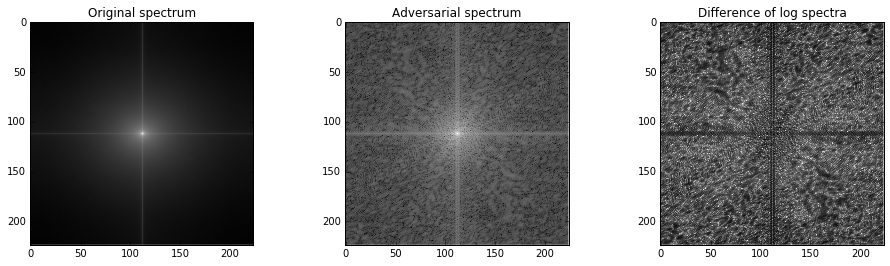

In [3]:
ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
ppt.imshow(np.log(original_spectrum[0, 0]), cmap='gray', interpolation='none')
ppt.title('Original spectrum')

ax = ppt.subplot(1, 3, 2)
ppt.imshow(np.log(adversarial_spectrum[0, 0]), cmap='gray', interpolation='none')
ppt.title('Adversarial spectrum')

ax = ppt.subplot(1, 3, 3)
ppt.imshow(difference_of_log_spectra[0, 0], cmap='gray', interpolation='none')
ppt.title('Difference of log spectra')

In [4]:
def activity_distribution(spectrum, range_bins, angle_bins):
    spectrum = spectrum.reshape(spectrum.shape[-2:])

    # Record the summed values at every distance and angle to the origin, and the number of summed values
    distance_distribution = np.zeros(shape=(2, range_bins))
    angle_distribution = np.zeros(shape=(2, angle_bins))
    
    center = np.asarray(spectrum.shape) / 2.0
    max_distance = math.ceil(np.linalg.norm(center))
    max_angle = 2 * math.pi
    
    it = np.nditer(spectrum, flags=['multi_index'])
    for value in it:
        distance = np.linalg.norm(np.asarray(it.multi_index) - center)
        distance_index = (distance / max_distance) * (range_bins - 1)
        distance_index = int(round(distance_index))
        
        angle = math.atan2(center[0] - it.multi_index[0], it.multi_index[1] - center[1])
        if angle < 0:
            angle += 2 * math.pi
        angle_index = (angle / max_angle) * (angle_bins - 1)
        angle_index = int(round(angle_index))
        
        distance_distribution[0, distance_index] += value
        distance_distribution[1, distance_index] += 1
        angle_distribution[0, angle_index] += value
        angle_distribution[1, angle_index] += 1
    
    distance_distribution = distance_distribution[0] / (distance_distribution[1] + 1)
    angle_distribution = angle_distribution[0] / (angle_distribution[1] + 1)
    
    return distance_distribution, angle_distribution

# Plot the distribution of frequencies over distance from the origin on a log scale
distance_bins = 256
angle_bins = 32
original_distance_distribution, original_angle_distribution = activity_distribution(original_spectrum, distance_bins, angle_bins)
adversarial_distance_distribution, adversarial_angle_distribution = activity_distribution(adversarial_spectrum, distance_bins, angle_bins)
diff_distance_distribution, diff_angle_distribution = activity_distribution(difference_of_log_spectra, distance_bins, angle_bins)

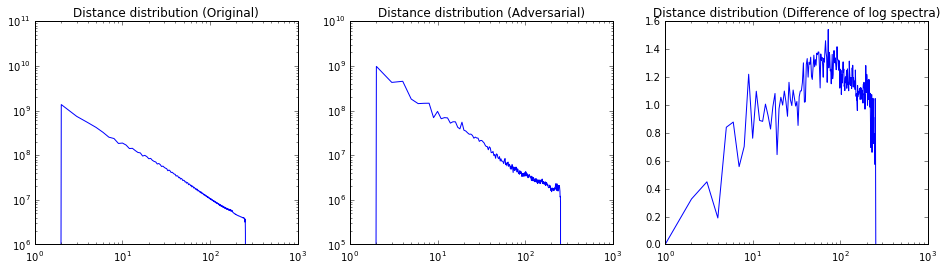

In [5]:
ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(original_distance_distribution)
ppt.title('Distance distribution (Original)')

ax = ppt.subplot(1, 3, 2)
ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(adversarial_distance_distribution)
ppt.title('Distance distribution (Adversarial)')

ax = ppt.subplot(1, 3, 3)
ax.set_xscale('log')
#ax.set_yscale('log')
ppt.plot(diff_distance_distribution)
ppt.title('Distance distribution (Difference of log spectra)')

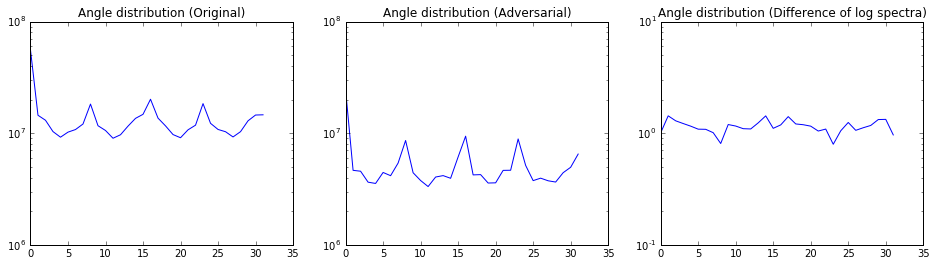

In [6]:
ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
#ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(original_angle_distribution)
ppt.title('Angle distribution (Original)')

ax = ppt.subplot(1, 3, 2)
#ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(adversarial_angle_distribution)
ppt.title('Angle distribution (Adversarial)')

ax = ppt.subplot(1, 3, 3)
#ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(diff_angle_distribution)
ppt.title('Angle distribution (Difference of log spectra)')